In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt

2025-08-10 18:03:09.560649: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754848989.807615      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754848989.879369      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
train_dir = "../input/fingers/train"
test_dir = "../input/fingers/test"
img_size = (128, 128)

def load_images_and_labels(directory):
    images = []
    labels = []
    for file in os.listdir(directory):
        file_path = os.path.join(directory, file)
        img = Image.open(file_path).resize(img_size)
        images.append(np.array(img))
        label_part = file.split('_')[1]  
        label = int(label_part[0])       
        labels.append(label)
    return np.array(images), np.array(labels)
train_images, Y_train = load_images_and_labels(train_dir)
test_images, Y_test = load_images_and_labels(test_dir)
print(Y_train[0])
print(f"Train images: {train_images.shape}, Train labels: {Y_train.shape}")
print(f"Test images: {test_images.shape}, Test labels: {Y_test.shape}")


4
Train images: (18000, 128, 128), Train labels: (18000,)
Test images: (3600, 128, 128), Test labels: (3600,)


In [4]:
X_train = train_images.reshape(-1, 128, 128, 1)
X_test = test_images.reshape(-1, 128, 128, 1)

In [5]:
from sklearn.model_selection import train_test_split
X_train = X_train / 255.0
X_test = X_test / 255.0
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

In [6]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 14400
number of test examples = 3600
X_train shape: (14400, 128, 128, 1)
Y_train shape: (14400,)
X_test shape: (3600, 128, 128, 1)
Y_test shape: (3600,)


In [7]:
from tensorflow.keras.utils import to_categorical

Y_train = to_categorical(Y_train, num_classes=12)
Y_test = to_categorical(Y_test, num_classes=12)

In [8]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 14400
number of test examples = 3600
X_train shape: (14400, 128, 128, 1)
Y_train shape: (14400, 12)
X_test shape: (3600, 128, 128, 1)
Y_test shape: (3600, 12)


In [9]:
import tensorflow.keras.layers as tfl

In [10]:
print(X_train.shape)  # Should be (14400, 128, 128, 1)
print(Y_train.shape)  # Should be (14400, 12)


(14400, 128, 128, 1)
(14400, 12)


In [11]:
def convolutional_model(input_shape):
    input_img = tf.keras.Input(shape=input_shape)
    
    Z1 = tfl.Conv2D(filters=8, kernel_size=(4, 4), strides=(1, 1), padding='same')(input_img)
    A1 = tfl.ReLU()(Z1)
    P1 = tfl.MaxPool2D(pool_size=(8, 8), strides=(8, 8), padding="same")(A1)
    
    Z2 = tfl.Conv2D(filters=16, kernel_size=(2, 2), strides=(1, 1), padding='same')(P1)
    A2 = tfl.ReLU()(Z2)
    P2 = tfl.MaxPool2D(pool_size=(4, 4), strides=(4, 4), padding="same")(A2)
    
    F = tfl.Flatten()(P2)
    outputs = tfl.Dense(units=12, activation='softmax')(F)

    model = tf.keras.Model(inputs=input_img, outputs=outputs)
    return model


In [12]:
conv_model = convolutional_model((128, 128, 1))
conv_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
conv_model.summary()
    
output = [['InputLayer', [(None, 128, 128, 1)], 0],
        ['Conv2D', (None, 128, 128, 8), 392, 'same', 'linear', 'GlorotUniform'],
        ['ReLU', (None, 64, 64, 8), 0],
        ['MaxPooling2D', (None, 8, 8, 8), 0, (8, 8), (8, 8), 'same'],
        ['Conv2D', (None, 8, 8, 16), 528, 'same', 'linear', 'GlorotUniform'],
        ['ReLU', (None, 8, 8, 16), 0],
        ['MaxPooling2D', (None, 2, 2, 16), 0, (4, 4), (4, 4), 'same'],
        ['Flatten', (None, 64), 0],
        ['Dense', (None, 12), 390, 'softmax']]
    

2025-08-10 18:05:04.645890: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 8)    │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 128, 128, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 16)     │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 12)             │         3,084 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,748 (14.64 KB)

 Trainable params: 3,748 (14.64 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).batch(64)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test)).batch(64)
history = conv_model.fit(train_dataset, epochs=30, validation_data=test_dataset)

Epoch 1/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 75s 267ms/step - accuracy: 0.4640 - loss: 1.5361 - val_accuracy: 0.8858 - val_loss: 0.3445
Epoch 2/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 48s 216ms/step - accuracy: 0.8789 - loss: 0.3441 - val_accuracy: 0.9256 - val_loss: 0.2162
Epoch 3/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 83s 222ms/step - accuracy: 0.9254 - loss: 0.2279 - val_accuracy: 0.9522 - val_loss: 0.1514
Epoch 4/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 80s 215ms/step - accuracy: 0.9491 - loss: 0.1646 - val_accuracy: 0.9669 - val_loss: 0.1105
Epoch 5/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 49s 217ms/step - accuracy: 0.9620 - loss: 0.1230 - val_accuracy: 0.9714 - val_loss: 0.0860
Epoch 6/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 48s 214ms/step - accuracy: 0.9707 - loss: 0.0944 - val_accuracy: 0.9792 - val_loss: 0.0698
Epoch 7/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 83s 218ms/step - accuracy: 0.9768 - loss: 0.0741 - val_accuracy: 0.9836 - val_loss: 0.0575
Epoch 8/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 82s 218ms/step - accuracy: 0.9816 - loss: 0

/tmp/ipykernel_13/973814028.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
/tmp/ipykernel_13/973814028.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)


[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

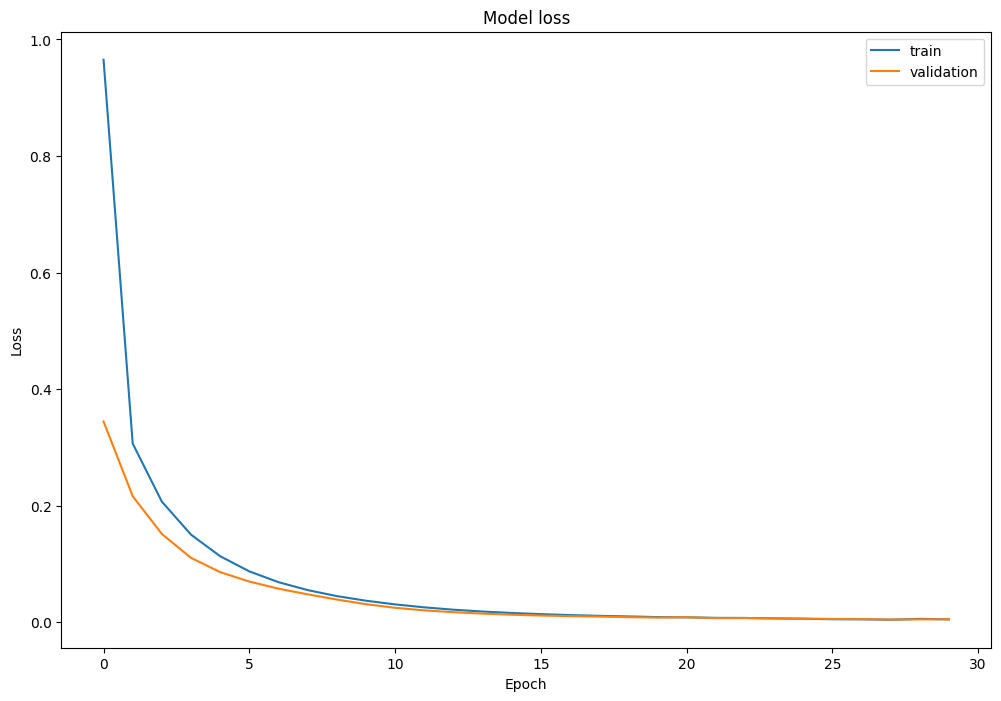

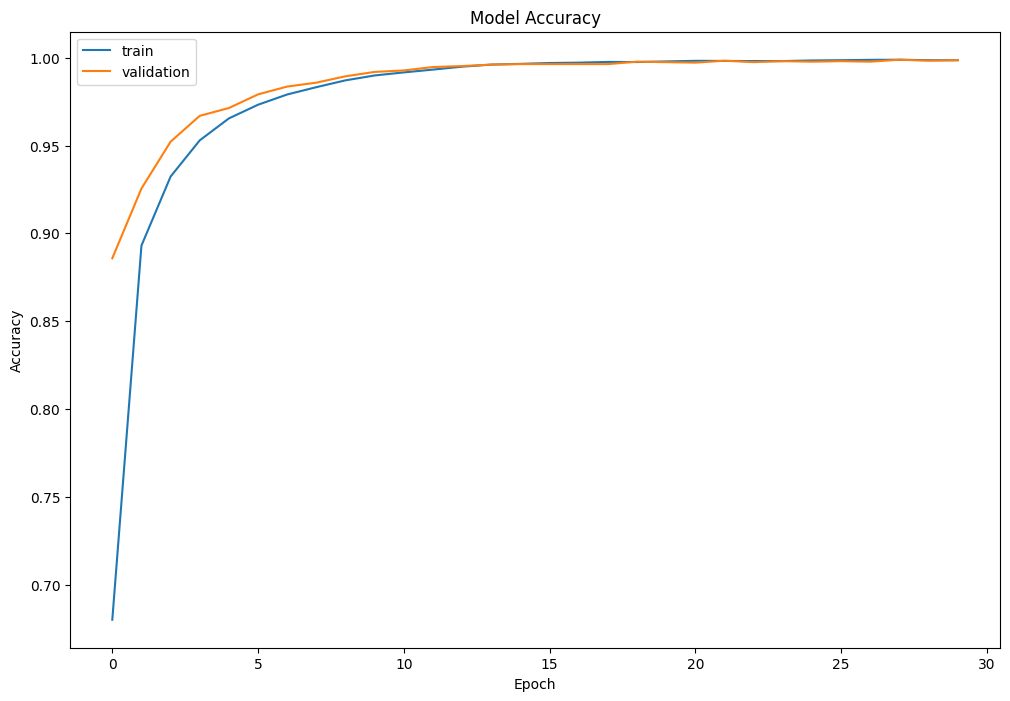

In [14]:
# The history.history["loss"] entry is a dictionary with as many values as epochs that the
# model was trained on. 
df_loss_acc = pd.DataFrame(history.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
df_loss.plot(title='Model loss',figsize=(12,8)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(12,8)).set(xlabel='Epoch',ylabel='Accuracy')

In [15]:
# Load and preprocess the image
img_path = '/kaggle/input/uploaded/dataset-card.jpg'
img = Image.open(img_path).convert('L')  # Convert to grayscale
img = img.resize((128, 128))             # Resize to match model input
img_array = np.array(img) / 255.0        # Normalize
img_array = img_array.reshape(1, 128, 128, 1)  # Add batch and channel dimensions


In [16]:
prediction = conv_model.predict(img_array)
predicted_class = np.argmax(prediction)
print("Predicted class:", predicted_class)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 934ms/step
Predicted class: 2


In [17]:
conv_model.save('/kaggle/working/hand_gesture_model.h5')

In [18]:
from tensorflow.keras.models import load_model

model = load_model('/kaggle/working/hand_gesture_model.h5')

In [19]:
prediction = model.predict(img_array)
predicted_class = np.argmax(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


In [20]:
def classify_hand_gesture(img_path, model):
    img = Image.open(img_path).convert('L')
    img = img.resize((128, 128))
    img_array = np.array(img) / 255.0
    img_array = img_array.reshape(1, 128, 128, 1)
    prediction = model.predict(img_array)
    return np.argmax(prediction)
